In [1]:
#全局变量
repo_id = 'lansinuote/diffusion.9.custom_diffusion'
checkpoint = 'CompVis/stable-diffusion-v1-4'

In [2]:
from diffusers import DDPMScheduler
from transformers import CLIPTokenizer

#加载两个工具类
scheduler = DDPMScheduler.from_pretrained(checkpoint, subfolder='scheduler')
tokenizer = CLIPTokenizer.from_pretrained(checkpoint, subfolder='tokenizer')

scheduler, tokenizer

(DDPMScheduler {
   "_class_name": "DDPMScheduler",
   "_diffusers_version": "0.17.0.dev0",
   "beta_end": 0.012,
   "beta_schedule": "scaled_linear",
   "beta_start": 0.00085,
   "clip_sample": false,
   "clip_sample_range": 1.0,
   "dynamic_thresholding_ratio": 0.995,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "sample_max_value": 1.0,
   "set_alpha_to_one": false,
   "skip_prk_steps": true,
   "steps_offset": 1,
   "thresholding": false,
   "trained_betas": null,
   "variance_type": "fixed_small"
 },
 CLIPTokenizer(name_or_path='CompVis/stable-diffusion-v1-4', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single

In [3]:
from datasets import load_dataset
import torchvision

#加载数据集
dataset = load_dataset(repo_id, split='train')

compose = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.Resize(
        512, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    torchvision.transforms.RandomCrop(512),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
])


def f(data):
    #应用图像数据增强
    pixel_values = [compose(i) for i in data['image']]

    #文字编码
    input_ids = tokenizer(data['prompt'],
                          truncation=True,
                          padding='max_length',
                          max_length=77,
                          return_tensors='pt').input_ids

    return {'pixel_values': pixel_values, 'input_ids': input_ids}


#因为图像增强在每一个epoch中是动态计算的,所以不能简单地用map处理
dataset = dataset.with_transform(f)

for k, v in dataset[0].items():
    print(k, v.shape, v.dtype)

dataset

Using custom data configuration lansinuote--diffusion.9.custom_diffusion-c303234c18848c12
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--diffusion.9.custom_diffusion-c303234c18848c12/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


pixel_values torch.Size([3, 512, 512]) torch.float32
input_ids torch.Size([77]) torch.int64


Dataset({
    features: ['image', 'prompt'],
    num_rows: 200
})

(512, 512, 3) float32 (64, 64) float32


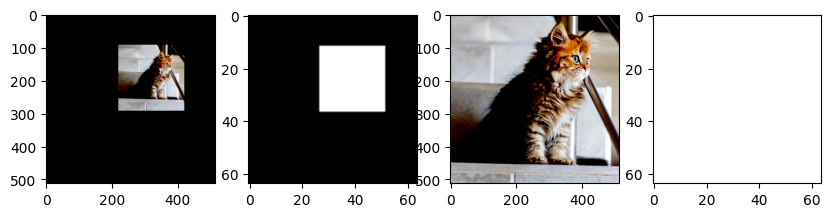

In [4]:
from matplotlib import pyplot as plt
import PIL.Image
import random
import numpy as np
import torch


#图像增强
def preprocess_instance(image, resize):
    #计算x和y的偏移量
    offset_y = random.randint(0, abs(resize - 512))
    offset_x = random.randint(0, abs(resize - 512))

    #缩放
    image = image.resize((resize, resize),
                         resample=PIL.Image.Resampling.BILINEAR)

    #压缩到正负1之间
    image = (np.array(image) / 127.5 - 1.0).astype(np.float32)

    out_image = np.zeros((512, 512, 3), dtype=np.float32)
    mask = np.zeros((512, 512))

    if resize > 512:
        #如果resize大于512,则说明原图被放大,需要裁减到512
        out_image = image[offset_y:offset_y + 512, offset_x:offset_x + 512]
        #因为是大图裁小,不存在填充,所以mask全1
        mask[:, :] = 1.0
    else:
        #否则说明原图被缩小,把缩小的图黏贴到黑色的背景上
        out_image[offset_y:offset_y + resize,
                  offset_x:offset_x + resize] = image
        #被黏贴的部分是1,剩下的是背景,maks是0
        mask[offset_y:offset_y + resize, offset_x:offset_x + resize] = 1.0

    #mask缩小到64*64
    mask = torch.FloatTensor(mask).unsqueeze(dim=0)
    mask = torchvision.transforms.Resize([64, 64])(mask).squeeze(dim=0).numpy()

    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0

    return out_image, mask


out_image1, mask1 = preprocess_instance(
    PIL.Image.open('instance_images/0.jpg'), 200)
out_image2, mask2 = preprocess_instance(
    PIL.Image.open('instance_images/0.jpg'), 600)

print(out_image1.shape, out_image1.dtype, mask1.shape, mask1.dtype)

plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(out_image1.clip(0, 1))
plt.subplot(1, 4, 2)
plt.imshow(mask1, cmap='gray', vmin=0.0, vmax=1.0)
plt.subplot(1, 4, 3)
plt.imshow(out_image2.clip(0, 1))
plt.subplot(1, 4, 4)
plt.imshow(mask2, cmap='gray', vmin=0.0, vmax=1.0)

plt.show()

In [5]:
def get_instance():
    #读取一张instance图片
    image = PIL.Image.open('instance_images/%d.jpg' % random.choice(range(5)))
    image = torchvision.transforms.RandomHorizontalFlip(0.5)(image)

    #随机图片尺寸
    scale = random.randint(614, 715)
    if random.random() < 0.66:
        scale = random.randint(170, 512)

    #增强图片,得到mask
    image, mask = preprocess_instance(image, scale)

    #根据增强的类型,对prompt也进行增强
    prompt = 'photo of a maorongrong cat'
    if scale < 307.2:
        prompt = random.choice(['a far away ', 'very small ']) + prompt
    if scale > 512:
        prompt = random.choice(['zoomed in ', 'close up ']) + prompt

    return {
        'pixel_values':
        torch.FloatTensor(image).permute(2, 0, 1),
        'mask':
        torch.FloatTensor(mask),
        'input_ids':
        tokenizer(prompt,
                  truncation=True,
                  padding='max_length',
                  max_length=77,
                  return_tensors='pt').input_ids.squeeze(dim=0)
    }


for k, v in get_instance().items():
    print(k, v.shape, v.dtype)

pixel_values torch.Size([3, 512, 512]) torch.float32
mask torch.Size([64, 64]) torch.float32
input_ids torch.Size([77]) torch.int64


In [6]:
def collate_fn(data):
    #取基础数据
    #[77]
    input_ids = data[0]['input_ids']
    #[3, 512, 512]
    pixel_values = data[0]['pixel_values']

    #取实例数据
    #input_ids -> [77]
    #pixel_values -> [3, 512, 512]
    #mask -> [64, 64]
    instance = get_instance()

    #合并
    #[2, 77]
    input_ids = torch.stack([input_ids, instance['input_ids']])
    #[2, 3, 512, 512]
    pixel_values = torch.stack([pixel_values, instance['pixel_values']])

    #mask变形
    mask = instance['mask'].reshape(1, 1, 64, 64)

    data = {'input_ids': input_ids, 'pixel_values': pixel_values, 'mask': mask}
    return data


loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=1,
                                     shuffle=True,
                                     collate_fn=collate_fn)

for k, v in next(iter(loader)).items():
    print(k, v.shape, v.dtype)

len(loader)

input_ids torch.Size([2, 77]) torch.int64
pixel_values torch.Size([2, 3, 512, 512]) torch.float32
mask torch.Size([1, 1, 64, 64]) torch.float32


200

In [7]:
from transformers.models.clip.modeling_clip import CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel

#加载预训练模型
encoder = CLIPTextModel.from_pretrained(checkpoint, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(checkpoint, subfolder='vae')
unet = UNet2DConditionModel.from_pretrained(checkpoint, subfolder='unet')

#添加新词
tokenizer.add_tokens('maorongrong')
encoder.resize_token_embeddings(len(tokenizer))

#初始化新词编码
#49408 = tokenizer.convert_tokens_to_ids('maorongrong')
#42170 = tokenizer.convert_tokens_to_ids('ktn')
token_embeds = encoder.get_input_embeddings().weight.data
token_embeds[49408] = token_embeds[42170]

#只训练词embed层
encoder.requires_grad_(False)
vae.requires_grad_(False)
unet.requires_grad_(False)
encoder.text_model.embeddings.token_embedding.requires_grad_(True)


def print_model_size(name, model):
    print(name, sum(i.numel() for i in model.parameters()) / 10000)


print_model_size('encoder', encoder)
print_model_size('vae', vae)
print_model_size('unet', unet)

encoder 12306.1248
vae 8365.3863
unet 85952.0964


In [8]:
from diffusers.models.attention_processor import CustomDiffusionAttnProcessor
from diffusers.loaders import AttnProcsLayers


#获取注意力层
def get_attn_processor():

    #根据unet的结构,做一个注意力层的字典
    attn_processor = {}
    for name, _ in unet.attn_processors.items():
        if name.startswith('mid_block'):
            #1280 = unet.config.block_out_channels[-1]
            hidden_size = 1280

        if name.startswith('up_blocks'):
            #[1280, 1280, 640, 320] = list(reversed(unet.config.block_out_channels))
            hidden_size = [1280, 1280, 640, 320][int(name[10])]

        if name.startswith('down_blocks'):
            #[320, 640, 1280, 1280] = unet.config.block_out_channels
            hidden_size = [320, 640, 1280, 1280][int(name[12])]

        train_kv = not name.endswith('attn1.processor')

        attn_processor[name] = CustomDiffusionAttnProcessor(
            train_kv=train_kv,
            train_q_out=False,
            hidden_size=hidden_size,
            #768 = unet.config.cross_attention_dim
            cross_attention_dim=768 if train_kv else None,
        )

        #加载参数
        if train_kv:
            param = {
                'to_k_custom_diffusion.weight':
                unet.state_dict()[name.split('.processor')[0] +
                                  '.to_k.weight'],
                'to_v_custom_diffusion.weight':
                unet.state_dict()[name.split('.processor')[0] +
                                  '.to_v.weight'],
            }
            attn_processor[name].load_state_dict(param)

    #设置注意力层到unet模型中,影响unet模型的行为
    unet.set_attn_processor(attn_processor)

    #封装为模型
    return AttnProcsLayers(unet.attn_processors)


attn_processor = get_attn_processor()

print_model_size('attn_processor', attn_processor)

attn_processor 1916.928


In [9]:
def get_parameters():
    return list(encoder.get_input_embeddings().parameters()) + list(
        attn_processor.parameters())


optimizer = torch.optim.AdamW(get_parameters(),
                              lr=2e-5,
                              betas=(0.9, 0.999),
                              weight_decay=0.01,
                              eps=1e-8)

criterion = torch.nn.MSELoss(reduction='none')

optimizer, criterion

(AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     eps: 1e-08
     foreach: None
     lr: 2e-05
     maximize: False
     weight_decay: 0.01
 ),
 MSELoss())

In [10]:
def get_loss(data):
    device = data['input_ids'].device

    #文字编码
    #[2, 77] -> [2, 77, 768]
    out_encoder = encoder(data['input_ids'])[0]

    #抽取图像特征图
    #[2, 3, 512, 512] -> [2, 4, 64, 64]
    out_vae = vae.encode(data['pixel_values']).latent_dist.sample()
    #0.18215 = vae.config.scaling_factor
    out_vae = out_vae * 0.18215

    #随机数,unet的计算目标
    noise = torch.randn_like(out_vae)

    #往特征图中添加噪声
    #1000 = scheduler.num_train_timesteps
    #2 = out_vae.shape[0]
    noise_step = torch.randint(0, 1000, (2, )).long()
    noise_step = noise_step.to(device)
    out_vae_noise = scheduler.add_noise(out_vae, noise, noise_step)

    #根据文字信息,把特征图中的噪声计算出来
    #[2, 4, 64, 64]
    out_unet = unet(out_vae_noise, noise_step, out_encoder).sample

    #拆分两部分计算结果,分别是基础的和instance的
    #[2, 4, 64, 64] -> [1, 4, 64, 64],[1, 4, 64, 64]
    out_unet, out_unet_instance = torch.chunk(out_unet, 2, dim=0)

    #噪声也是分为两部分的
    #[2, 4, 64, 64] -> [1, 4, 64, 64],[1, 4, 64, 64]
    noise, noise_instance = torch.chunk(noise, 2, dim=0)

    #基础部分的loss可以直接计算mse loss
    loss = criterion(out_unet, noise).mean()

    #instance部分首先简单地计算mse loss,不reduce,后续还要处理mask
    #[1, 4, 64, 64],[1, 4, 64, 64] -> [1, 4, 64, 64]
    loss_instance = criterion(out_unet_instance, noise_instance)

    #loss和mask相乘,pad的部分loss为0
    #[1, 4, 64, 64]*[1, 4, 64, 64] -> [1, 4, 64, 64]
    loss_instance = loss_instance * data['mask']

    #求和求平均
    #[1, 4, 64, 64] -> [1] -> scala
    loss_instance = loss_instance.sum([1, 2, 3]) / data['mask'].sum([1, 2, 3])
    loss_instance = loss_instance.mean()

    #两部分loss求和即可
    return loss_instance + loss


get_loss({
    'input_ids': torch.ones(2, 77).long(),
    'pixel_values': torch.randn(2, 3, 512, 512),
    'mask': torch.ones(1, 1, 64, 64)
})

tensor(1.5815, grad_fn=<AddBackward0>)

In [11]:
def train():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    unet.to(device)
    encoder.to(device)
    vae.to(device)
    unet.train()

    loss_sum = 0
    for epoch in range(5):
        for i, data in enumerate(loader):
            for k in data.keys():
                data[k] = data[k].to(device)

            loss = get_loss(data)
            loss.backward()
            loss_sum += loss.item()

            torch.nn.utils.clip_grad_norm_(get_parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 1 == 0:
            print(epoch, loss_sum)
            loss_sum = 0

    #保存词编码
    torch.save({'maorongrong': encoder.get_input_embeddings().weight[49408]},
               './save/embed_weight.bin')

    #保存注意力层参数
    unet.save_attn_procs('./save')


train()

0 160.5251718647778
1 152.0645466875285
2 158.88694583065808
3 156.2355902325362
4 134.70489627867937
